In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import tensorflow as tf

df = pd.read_excel('data/state_month_overdose.xlsx')

df['Deaths'] = df['Deaths'].apply(lambda x: 0 if x == 'Suppressed' else int(x))

df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

df = df.reset_index() #2015/01
df['Month Code'] = pd.to_datetime(df['Month Code'])#.reset_index() #2015-01-01
# df.set_index('Month', inplace=True)
df = df.groupby(['Month']).agg({'Deaths': 'sum'}).reset_index()



train = df[df['Month'] <= '2020-02-01']
test = df[df['Month'] >= '2020-02-01']
testog = test
test = test.reset_index().drop(columns = ['index'])



# Modify the create_dataset function to use a lookback of 3 months
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset.iloc[i:(i + look_back)]  # Collect the previous 'look_back' months
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back])  # The target is the subsequent month
    return np.array(dataX), np.array(dataY)

# Update lookback to 3 months
look_back = 9
trainX, trainY = create_dataset(train['Deaths'], look_back)
testX, testY = create_dataset(test['Deaths'], look_back)

# Reshape inputs to match LSTM input requirements (samples, time_steps, features)
trainX = trainX.reshape((trainX.shape[0], look_back, 1))
testX = testX.reshape((testX.shape[0], look_back, 1))

# Rebuild the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# Updated generate_forecast function to handle 3-month lookback
def generate_forecast(model, initial_sequence, num_predictions=12, look_back=3):
    predictions = []
    for _ in range(num_predictions):
        # Generate the next prediction
        next_prediction = model.predict(initial_sequence)
        predictions.append(next_prediction[0][0])
        
        # Update the sequence with the new prediction
        new_sequence = np.append(initial_sequence[0, 1:], [[next_prediction[0][0]]], axis=0)
        initial_sequence = new_sequence.reshape((1, look_back, 1))

    return np.array(predictions)

# Prepare the initial sequence for forecasting using the last `look_back` months from training
initial_sequence = trainX[-1].reshape((1, look_back, 1))

# Generate test predictions with the updated lookback logic
testPredict = generate_forecast(model, initial_sequence, num_predictions=10, look_back=look_back)
trainPredict = model.predict(trainX)

# Flatten predictions for visualization and evaluation
testPredictlst = testPredict.flatten().tolist()
trainPredictlst = trainPredict.flatten().tolist()

# Combine actual data and predictions
combined_array = [0] * look_back + trainPredictlst + testPredictlst
df['LSTM Predictions'] = combined_array




sarima_model = SARIMAX(train['Deaths'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)
sarima_predictions = sarima_result.predict(start=0, end=len(train) + len(test) - 1, dynamic=False)

df['SARIMA Predictions'] = sarima_predictions

df.to_csv('9month_predictionresults.csv')

plottable = df.iloc[1:] #only taking rows with predictions so excluding part included in first lookback
plottable.set_index('Month', inplace=True)

2024-12-19 13:24:47.844848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 13:24:47.861574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 13:24:47.879871: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 13:24:47.885106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 13:24:47.901120: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/100


/home/sukikrishna/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7910262.5000
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 192357.8125
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 238268.0000
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76609.5859
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69108.8438
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88235.9297
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63571.1289
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70965.6562
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90504.2891
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62514.2695
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109442.3125
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79158.7422
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58161.9219
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58012.2695
Epoch 15/100
53/53 ━━━

In [2]:
print(len(testY))
testY

2


array([5613, 5792])

In [3]:
trainY

array([2970, 2739, 2718, 3098, 3416, 3721, 3608, 3475, 3384, 3668, 3624,
       3518, 3695, 3745, 4044, 4332, 4006, 4252, 4056, 4129, 3950, 3980,
       4000, 4022, 3832, 3820, 4017, 4008, 3671, 4155, 3922, 4079, 4063,
       4085, 4061, 3882, 3999, 3692, 3976, 3931, 3727, 4285, 3934, 4100,
       4112, 4296, 4371, 4252, 4529, 4560, 4645, 4727, 4696])

In [4]:
print(len(testPredict))
testPredict

10


array([4728.642 , 4803.731 , 4882.888 , 4954.236 , 5025.8027, 5113.9443,
       5184.3926, 5258.4497, 5331.9653, 5405.5347], dtype=float32)

In [5]:
testPredict[:len(testY)]

array([4728.642, 4803.731], dtype=float32)

In [6]:
len(sarima_predictions[1:len(trainPredict)+1])

53

In [7]:
sarima_predictions[len(trainPredict):len(trainPredict)+len(testY)]

53    3981.997153
54    4184.037754
Name: predicted_mean, dtype: float64

In [8]:
trainPredict

array([[2988.8328],
       [3015.0935],
       [3023.779 ],
       [3000.7834],
       [3035.323 ],
       [3111.2527],
       [3244.9573],
       [3352.572 ],
       [3430.5276],
       [3485.5168],
       [3574.0222],
       [3678.9055],
       [3764.3726],
       [3826.1912],
       [3861.3557],
       [3905.8923],
       [4001.3384],
       [4068.0845],
       [4166.3306],
       [4215.957 ],
       [4276.268 ],
       [4323.341 ],
       [4352.2637],
       [4372.906 ],
       [4367.123 ],
       [4311.536 ],
       [4283.9424],
       [4258.8213],
       [4254.4937],
       [4203.175 ],
       [4225.424 ],
       [4219.9937],
       [4230.661 ],
       [4241.3013],
       [4270.634 ],
       [4295.3486],
       [4282.0977],
       [4282.3296],
       [4276.932 ],
       [4255.8047],
       [4254.808 ],
       [4212.3877],
       [4238.8096],
       [4226.2705],
       [4233.122 ],
       [4262.297 ],
       [4303.213 ],
       [4380.977 ],
       [4418.83  ],
       [4490.3633],


LSTM
Train Score: 279.06 RMSE
Test Score: 937.75 RMSE
SARIMA
Train Score: 493.12 RMSE
Test Score: 1619.52 RMSE


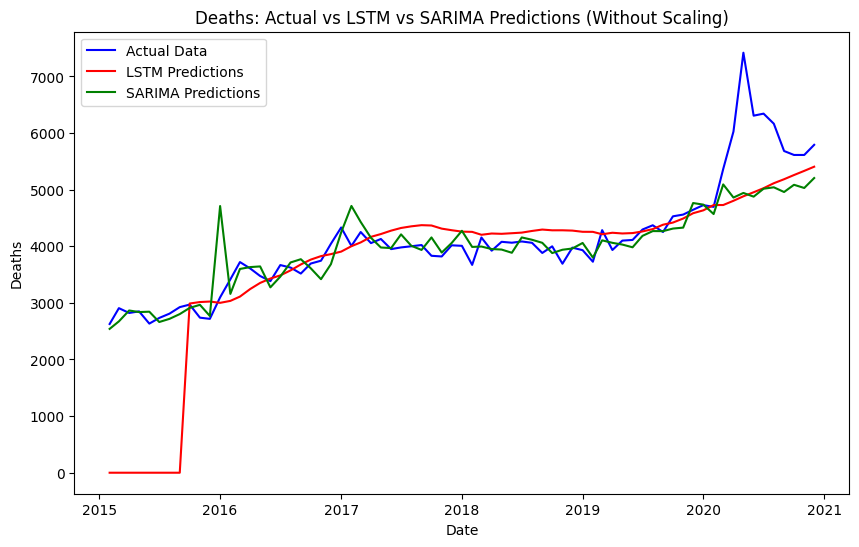

In [9]:
# LSTM calculate root mean squared error
print('LSTM')
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict[:len(testY)]))
print('Test Score: %.2f RMSE' % (testScore))

#SARIMA Error Metrics
print('SARIMA')
trainScore = np.sqrt(mean_squared_error(trainY, sarima_predictions[1:len(trainPredict)+1]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, sarima_predictions[len(trainPredict):len(trainPredict)+len(testY)]))
print('Test Score: %.2f RMSE' % (testScore))

plt.figure(figsize=(10, 6))
plt.plot(plottable.index, plottable['Deaths'], label='Actual Data', color='blue')
plt.plot(plottable.index, plottable['LSTM Predictions'], label='LSTM Predictions', color='red')
plt.plot(plottable.index, plottable['SARIMA Predictions'], label='SARIMA Predictions', color='green')
plt.title('Deaths: Actual vs LSTM vs SARIMA Predictions (Without Scaling)')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.show()

In [10]:
def calculate_confidence_intervals(predictions, alpha=0.05):
    # Calculate mean and standard deviation
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    
    # Calculate the z-score for the confidence level
    z_score = 1.96  # for 95% confidence
    margin_of_error = z_score * (std_pred / np.sqrt(len(predictions)))
    
    lower_bound = predictions - margin_of_error
    upper_bound = predictions + margin_of_error
    
    return lower_bound, upper_bound

sarimaTestPredict = df[df['Month'] > '2020-01-01']['SARIMA Predictions']
# Calculate confidence intervals
lower_bound_test, upper_bound_test = calculate_confidence_intervals(testPredict)
lower_bound_sarima, upper_bound_sarima = calculate_confidence_intervals(sarimaTestPredict)

In [11]:
sarimaTestPredict

61    4569.357214
62    5092.554794
63    4860.585533
64    4942.206500
65    4876.638922
66    5016.516000
67    5041.705897
68    4958.628025
69    5086.221253
70    5029.753481
71    5205.366131
Name: SARIMA Predictions, dtype: float64

In [12]:
testPredict

array([4728.642 , 4803.731 , 4882.888 , 4954.236 , 5025.8027, 5113.9443,
       5184.3926, 5258.4497, 5331.9653, 5405.5347], dtype=float32)

In [13]:
def calculate_overlap(lower1, upper1, lower2, upper2):
    # Initialize overlap count
    overlap_count = 0

    for l1, u1, l2, u2 in zip(lower1, upper1, lower2, upper2):
        # Check for overlap
        if u1 >= l2 and l1 <= u2:
            overlap_count += 1

    # Calculate percent overlap
    percent_overlap = (overlap_count / len(lower1)) * 100
    return percent_overlap

# Calculate percent overlap
percent_overlap = calculate_overlap(lower_bound_test, upper_bound_test, lower_bound_sarima, upper_bound_sarima)

print(f'Percent Overlap: {percent_overlap:.2f}%')

Percent Overlap: 60.00%


In [14]:
plottable

,Deaths,LSTM Predictions,SARIMA Predictions
Month,,,
2015-02-01,2627,0.000000,2540.838172
2015-03-01,2907,0.000000,2673.336257
2015-04-01,2822,0.000000,2865.711655
2015-05-01,2850,0.000000,2837.851862
2015-06-01,2634,0.000000,2844.503804
...,...,...,...
2020-08-01,6165,5113.944336,5041.705897
2020-09-01,5683,5184.392578,4958.628025
2020-10-01,5613,5258.449707,5086.221253
